## Pollen Detection In Honey Bee Images

Given images of honeybees, let's try to detect pollen in a given image.

We will use a Tensorflow/Keras convolutional neural network to make our predictions. 

Data Source: https://www.kaggle.com/datasets/ivanfel/honey-bee-pollen

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("PollenDataset/pollen_data.csv", usecols=['filename', 'pollen_carrying'])
data

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


### Preprocessing

In [5]:
def preprocess_df(df, image_path):
    df = df.copy()

    # Change filenames into filepaths
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)

    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].replace({0: "NO POLLEN", 1: "POLLEN"})

    # Train test split
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)
    
    return train_df, test_df

In [20]:
train_df, test_df = preprocess_df(data, image_path="PollenDataset/images")

In [22]:
# View an image
img = Image.open(train_df['filename'].iloc[0])
img.show()

#### Creating Generators

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size=(224, 224),
    color_mode = "rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size=(224, 224),
    color_mode = "rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size=(224, 224),
    color_mode = "rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 400 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


### Training

In [30]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu")(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer= 'adam',
    loss = 'binary_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs=100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


2024-09-23 22:18:52.719457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5075

2024-09-23 22:19:02.568555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 11s 727ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6947 - val_accuracy: 0.4545
Epoch 2/100
13/13 [==============================] - 8s 606ms/step - loss: 0.6922 - accuracy: 0.5275 - val_loss: 0.6994 - val_accuracy: 0.4545
Epoch 3/100
13/13 [==============================] - 7s 545ms/step - loss: 0.6929 - accuracy: 0.5275 - val_loss: 0.6949 - val_accuracy: 0.4545
Epoch 4/100
13/13 [==============================] - 7s 543ms/step - loss: 0.6909 - accuracy: 0.5275 - val_loss: 0.6956 - val_accuracy: 0.4545
Epoch 5/100
13/13 [==============================] - 7s 538ms/step - loss: 0.6894 - accuracy: 0.5275 - val_loss: 0.6958 - val_accuracy: 0.4545
Epoch 6/100
13/13 [==============================] - 7s 556ms/step - loss: 0.6864 - accuracy: 0.5275 - val_loss: 0.6877 - val_accuracy: 0.4545
Epoch 7/100
13/13 [==============================] - 7s 530ms/step - loss: 0.6835 - accuracy: 0.5500 - val_loss: 0.7189 - val_accuracy: 0.4545
Epoch 8/10

### Results

In [33]:
results = model.evaluate(test_images, verbose=0)

print("Accuracy: {:.2f}%".format(results[1]*100))

2024-09-23 22:27:53.810092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Accuracy: 85.58%


In [42]:
predictions = model.predict(test_images)

2024-09-23 22:30:46.907085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 1s 143ms/step


In [43]:
predictions

array([[0.03588409],
       [0.06758893],
       [0.03432301],
       [0.43099245],
       [0.1902962 ],
       [0.10991754],
       [0.9335611 ],
       [0.132006  ],
       [0.9260248 ],
       [0.63722426],
       [0.7285514 ],
       [0.5418779 ],
       [0.0458638 ],
       [0.7414714 ],
       [0.04781716],
       [0.22749326],
       [0.9701183 ],
       [0.12162264],
       [0.09764114],
       [0.03674377],
       [0.6738011 ],
       [0.7001194 ],
       [0.6848503 ],
       [0.9444714 ],
       [0.306594  ],
       [0.5349658 ],
       [0.81268215],
       [0.56717575],
       [0.12679139],
       [0.05120732],
       [0.70080394],
       [0.6491088 ],
       [0.79489595],
       [0.6643804 ],
       [0.6027652 ],
       [0.63634425],
       [0.9763046 ],
       [0.12467706],
       [0.92181504],
       [0.0571884 ],
       [0.11014063],
       [0.09935111],
       [0.16358477],
       [0.68190825],
       [0.04600981],
       [0.75310713],
       [0.596792  ],
       [0.039

In [44]:
predictions = np.squeeze(predictions >= 0.5, 1).astype(np.int)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [45]:
# True labels
test_images.labels

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1]

In [46]:
test_images.class_indices

{'NO POLLEN': 0, 'POLLEN': 1}

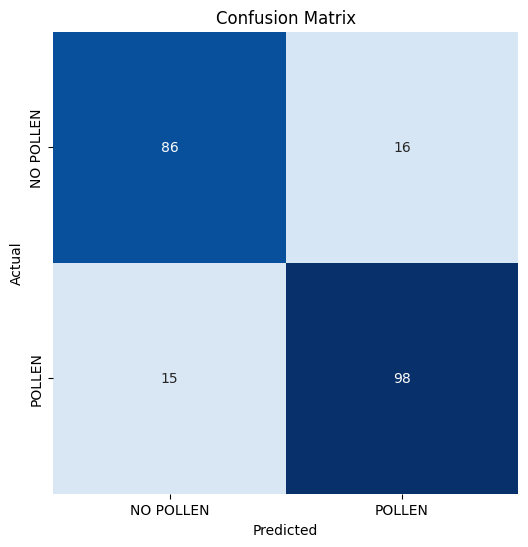

In [47]:
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=['NO POLLEN', 'POLLEN'])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['NO POLLEN', 'POLLEN'])
plt.yticks(ticks=[0.5, 1.5], labels=['NO POLLEN', 'POLLEN'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
print("Classification Report: \n-------------", clr)

Classification Report: 
-------------               precision    recall  f1-score   support

   NO POLLEN       0.85      0.84      0.85       102
      POLLEN       0.86      0.87      0.86       113

    accuracy                           0.86       215
   macro avg       0.86      0.86      0.86       215
weighted avg       0.86      0.86      0.86       215



In [53]:
test_images[0][0][5].shape

(224, 224, 3)

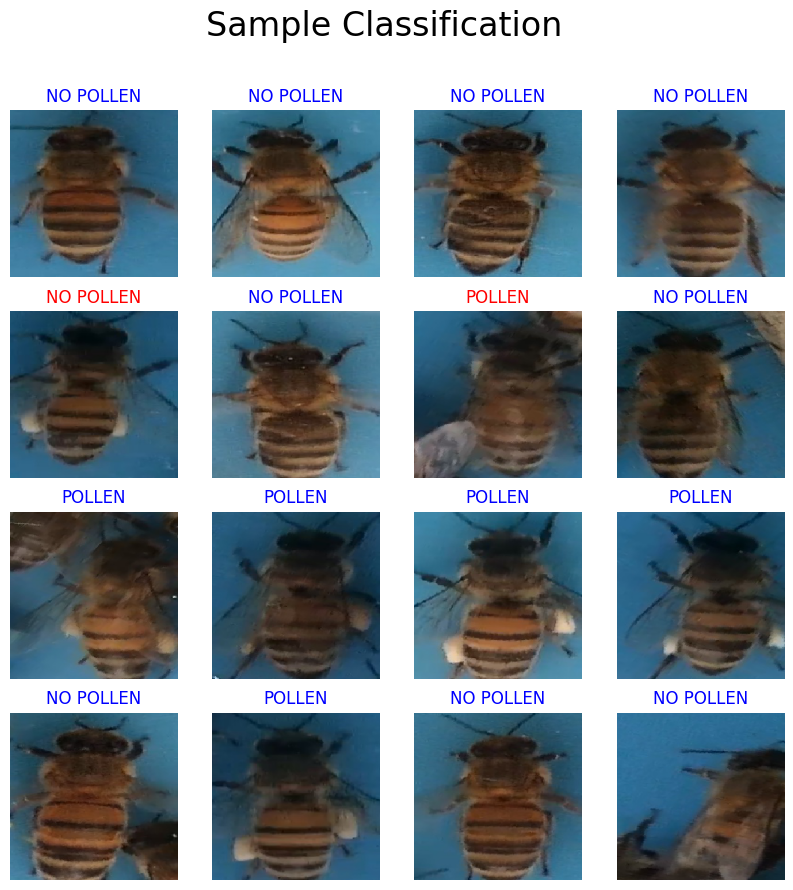

In [59]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title(
        "NO POLLEN" if predictions[i]==0 else "POLLEN",
        color="blue" if predictions[i] == test_images.labels[i] else 'red'
    )
    plt.axis('off')
plt.suptitle('Sample Classification', size=24)
plt.show()